# Example with the New York head model

In [1]:
%matplotlib inline
import os
import h5py
import numpy as np
import matplotlib.pyplot as plt
from ECSbook_simcode.plotting_convention import mark_subplots, simplify_axes

# This is the url the lead field is downloaded from:
#nyhead_url = 'https://www.parralab.org/nyhead/sa_nyhead.mat'

nyhead_file = os.path.join("sa_nyhead.mat")
head_data = h5py.File(nyhead_file, 'r')["sa"]
lead_field_normal = np.array(head_data["cortex75K"]["V_fem_normal"])
#lead_field = np.array(head_data["cortex75K"]["V_fem"])
cortex = np.array(head_data["cortex75K"]["vc"]) # Locations of every vertex in cortex
elecs = np.array(head_data["locs_3D"]) # 3D locations of electrodes
#elecs_2D = np.array(head_data["locs_2D"]) # 2D locations of electrodes

head_tri = np.array(head_data["head"]["tri"]).T - 1 # For 3D plotting
head_vc = np.array(head_data["head"]["vc"])
cortex_tri = np.array(head_data["cortex75K"]["tri"]).T - 1 # For 3D plotting
x_ctx, y_ctx, z_ctx = cortex
x_h, y_h, z_h = head_vc[0, :], head_vc[1, :], head_vc[2, :]
num_elecs = elecs.shape[1]

upper_idxs = np.where(elecs[2, :] > 0)[0]
elecs = elecs[:, upper_idxs]


### The following block is just needed to rotate and plot EEG electrode surfaces

In [2]:
from mpl_toolkits.mplot3d import art3d
from matplotlib.patches import Circle
def rotation_matrix(d):
    """
    Calculates a rotation matrix given a vector d. The direction of d
    corresponds to the rotation axis. The length of d corresponds to
    the sin of the angle of rotation.

    Variant of: http://mail.scipy.org/pipermail/numpy-discussion/2009-March/040806.html
    """
    sin_angle = np.linalg.norm(d)

    if sin_angle == 0:
        return np.identity(3)

    d /= sin_angle

    eye = np.eye(3)
    ddt = np.outer(d, d)
    skew = np.array([[    0,  d[2],  -d[1]],
                  [-d[2],     0,  d[0]],
                  [d[1], -d[0],    0]], dtype=np.float64)

    M = ddt + np.sqrt(1 - sin_angle**2) * (eye - ddt) + sin_angle * skew
    return M

def pathpatch_2d_to_3d(pathpatch, z=0, normal='z'):
    """
    Transforms a 2D Patch to a 3D patch using the given normal vector.

    The patch is projected into they XY plane, rotated about the origin
    and finally translated by z.
    """
    if type(normal) is str: #Translate strings to normal vectors
        index = "xyz".index(normal)
        normal = np.roll((1.0,0,0), index)

    normal /= np.linalg.norm(normal) #Make sure the vector is normalised

    path = pathpatch.get_path() #Get the path and the associated transform
    trans = pathpatch.get_patch_transform()

    path = trans.transform_path(path) #Apply the transform

    pathpatch.__class__ = art3d.PathPatch3D #Change the class
    pathpatch._code3d = path.codes #Copy the codes
    pathpatch._facecolor3d = pathpatch.get_facecolor #Get the face color

    verts = path.vertices #Get the vertices in 2D

    d = np.cross(normal, (0, 0, 1)) #Obtain the rotation vector
    M = rotation_matrix(d) #Get the rotation matrix

    pathpatch._segment3d = np.array([np.dot(M, (x, y, 0)) + (0, 0, z) for x, y in verts])

def pathpatch_translate(pathpatch, delta):
    """
    Translates the 3D pathpatch by the amount delta.
    """
    pathpatch._segment3d += delta


In [3]:

dt = 0.1
tstop = 10
num_tsteps = int(tstop / dt + 1)
tvec = np.arange(num_tsteps) * dt

tau1 = 1
tau2 = 0.2
# Current dipole moment (assumed to be oriented along the cortical normal)
p_z = np.zeros(num_tsteps)
p_z[50:] = (np.exp(-tvec[:-50] / tau1) - np.exp(-tvec[:-50] / tau2))
p_z *= 1e7 / np.max(np.abs(p_z))

dipole_loc = np.array([-10., 0., 88.]) # x, y, z location in mm
vertex_idx = np.argmin(np.sqrt(np.sum((dipole_loc[:, None] - cortex)**2, axis=0)))

# Calculate EEG signal from lead field. 
eeg = np.zeros((num_elecs, num_tsteps))
eeg[:, :] = lead_field_normal[vertex_idx, :][:, None] * p_z.T * 1e-6  # µV

eeg = eeg[upper_idxs, :]

# Find closest electrode
top_elec_idx = np.argmin(np.sqrt(np.sum((cortex[:, vertex_idx, None] - 
                       elecs[:3, :])**2, axis=0)))
max_time_idx = np.argmax(np.abs(eeg[top_elec_idx]))

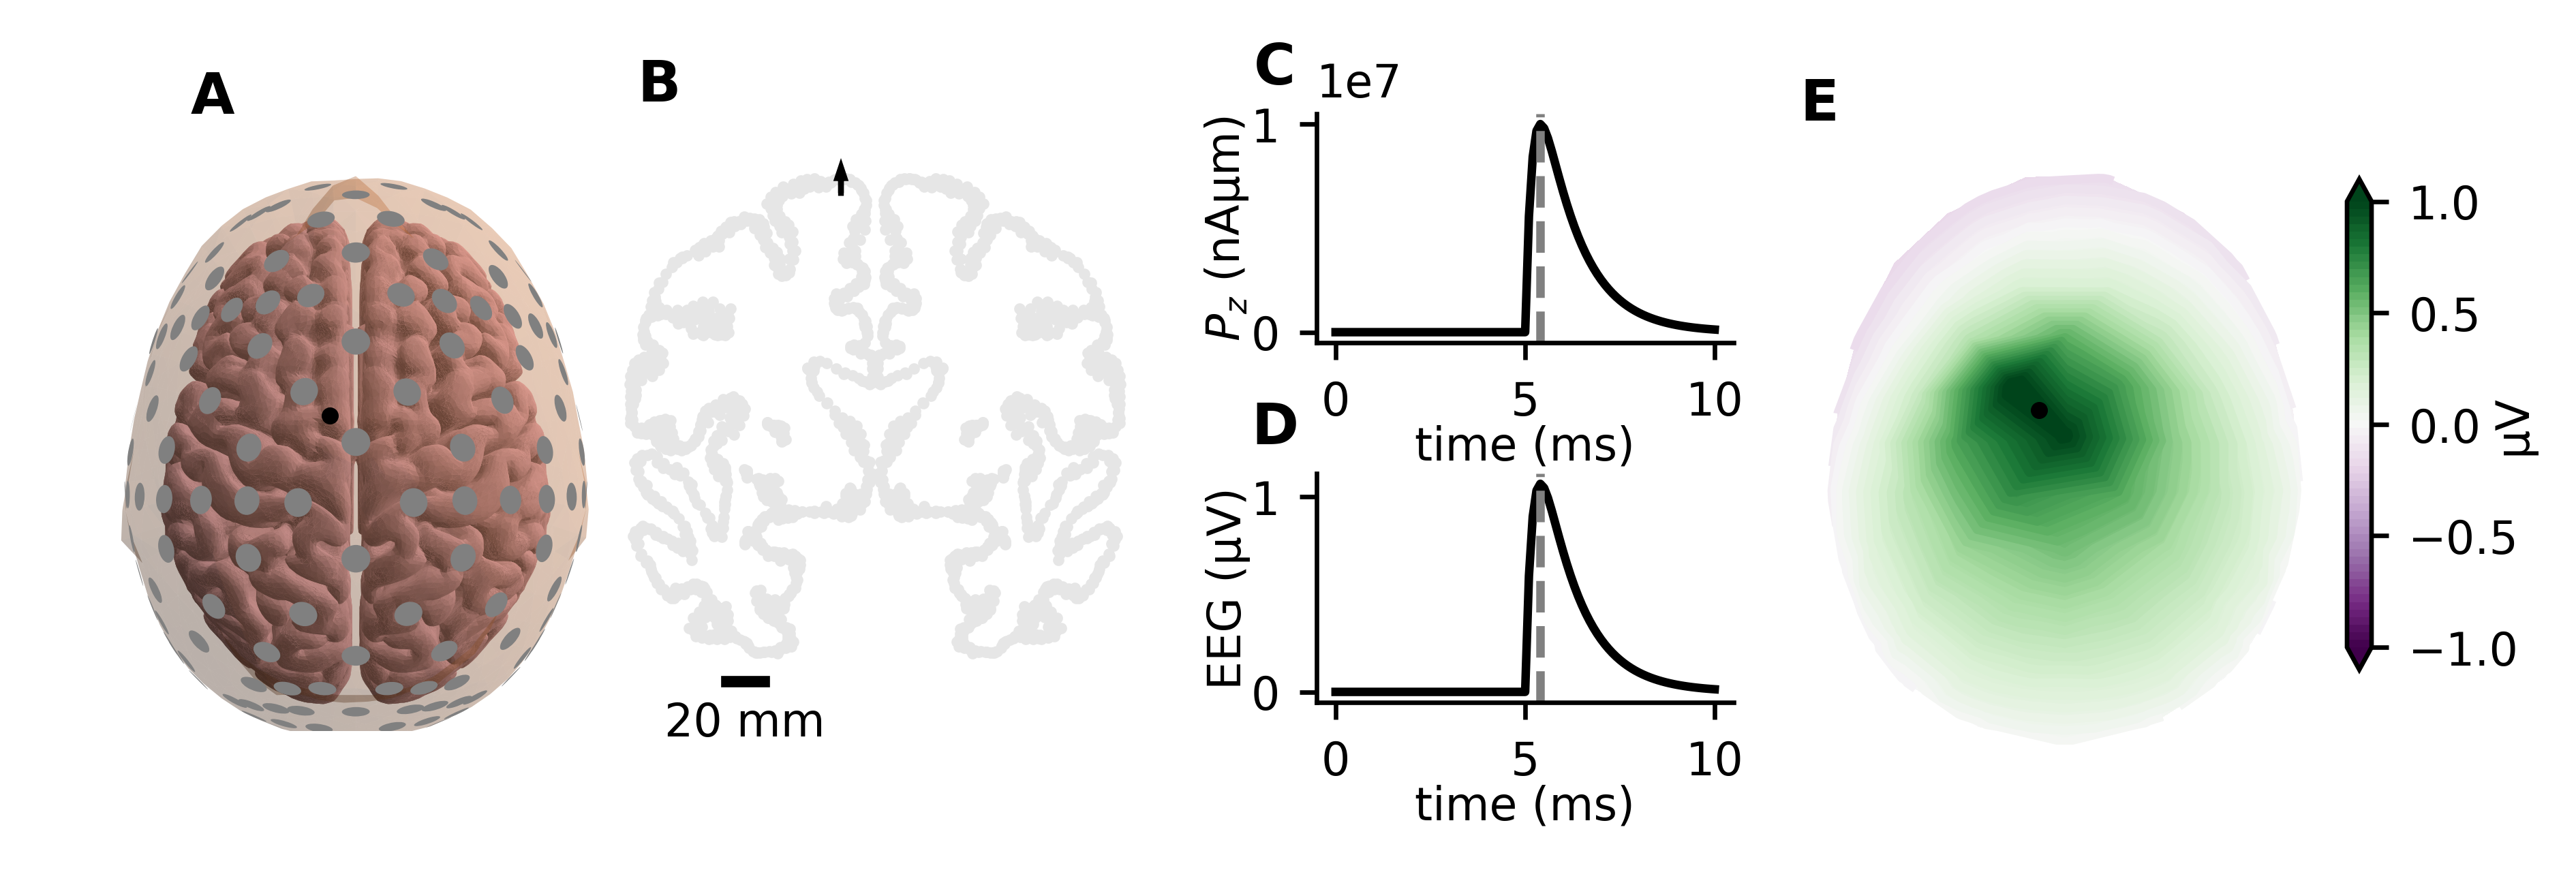

In [5]:
# The rest is just plotting

fig = plt.figure(figsize=[6, 2.])
fig.subplots_adjust(bottom=0.17, right=0.93, left=0.01, 
                    top=0.9, wspace=.1, hspace=0.6)

# Plot 3D head
ax_head = fig.add_axes([-.02, 0, 0.25, 1], projection='3d', frame_on=False,
                          xticks=[], yticks=[], zticks=[],
                          xlim=[-70, 70], facecolor="none",
                          ylim=[-70, 70], zlim=[-70, 70],
                          computed_zorder=False,
                          )

ax_geom = fig.add_axes([0.21, 0, 0.22, 1], aspect=1, #xlabel="x (mm)", 
                      #ylabel="z (mm)", 
                       frameon=False, 
                      xticks=[], yticks=[])

ax_p = fig.add_axes([0.5, 0.6, 0.17, 0.28], xlabel="time (ms)", ylabel="$P_z$ (nAµm)")

ax_eeg1 = fig.add_axes([0.5, 0.16, 0.17, 0.28], xlabel="time (ms)", ylabel="EEG (µV)")

ax_eeg2 = fig.add_axes([0.68, 0., 0.25, 1], xlim=[-110, 110], 
                       ylim=[-120, 110], aspect=1, #xlabel="x (mm)", 
                      #ylabel="y (mm)", 
                       frameon=False, 
                      xticks=[], yticks=[])


ax_head.axis('off')
ax_head.plot_trisurf(x_ctx, y_ctx, z_ctx, triangles=cortex_tri,
                              color="pink", zorder=0, rasterized=True)

ax_head.plot_trisurf(x_h, y_h, z_h, triangles=head_tri, 
                     color="#c87137", zorder=0, alpha=0.2)
all_patches = []                     
for elec_idx in range(len(elecs[0, :])):
    elec_normal = elecs[3:, elec_idx]
    elec_xyz = elecs[:3, elec_idx]
    p = Circle((0, 0), 5, facecolor='gray', zorder=elec_xyz[2],
               ) #Add a circle in the xy plane
    all_patches.append(p)
    ax_head.add_patch(p)
    pathpatch_2d_to_3d(p, z=0, normal=elec_normal)
    pathpatch_translate(p, elec_xyz)

ax_head.view_init(elev=90., azim=-90)
fig.text(0.05, 0.9, "A",
                horizontalalignment='center',
                verticalalignment='center',
                fontweight='demibold',
                fontsize=10)
ax_p.plot(tvec, p_z, c='k')
ax_eeg1.plot(tvec, eeg[top_elec_idx], c='k')
ax_p.axvline(tvec[max_time_idx], ls='--', c='gray')
ax_eeg1.axvline(tvec[max_time_idx], ls='--', c='gray')


cax = fig.add_axes([0.92, 0.2, 0.01, 0.6]) # This axis is just the colorbar

vmax = np.floor(np.max(np.abs(eeg[:, max_time_idx])))


cmap = plt.cm.get_cmap('PRGn') 
vmap = lambda v: cmap((v + vmax) / (2*vmax))
levels = np.linspace(-vmax, vmax, 60)

contourf_kwargs = dict(levels=levels, 
                       cmap="PRGn", 
                       vmax=vmax, 
                       vmin=-vmax,
                      extend="both")
scatter_params = dict(cmap="bwr", vmin=-vmax, vmax=vmax, s=25)

# Plot 3D location EEG electrodes

img = ax_eeg2.tricontourf(elecs[0], elecs[1], eeg[:, max_time_idx], **contourf_kwargs)
ax_eeg2.tricontour(elecs[0], elecs[1], eeg[:, max_time_idx], **contourf_kwargs)

cbar = plt.colorbar(img, cax=cax)
cbar.set_label("µV", labelpad=-5)
cbar.set_ticks([-vmax, -vmax/2, 0, vmax/2, vmax])


# Plotting crossection of cortex around active region center
threshold = 2  # threshold in mm for including points in plot
xz_plane_idxs = np.where(np.abs(cortex[1, :] - 
                                dipole_loc[1]) < threshold)[0]

ax_geom.scatter(cortex[0, xz_plane_idxs], 
            cortex[2, xz_plane_idxs], s=1, c='0.9')

ax_geom.plot([-30, -40], [-60, -60], c='k', lw=2)
ax_geom.text(-35, -65, "20 mm", ha='center', va="top")
ax_geom.arrow(cortex[0, vertex_idx], cortex[2, vertex_idx] - 4, 0, 4, 
          color='k', head_width=2)
        
ax_eeg2.plot(cortex[0, vertex_idx], cortex[1, vertex_idx], 'o', c='k', ms=2)
ax_head.plot(cortex[0, vertex_idx], cortex[1, vertex_idx], cortex[2, vertex_idx], 'o', c='k', ms=2)
    
simplify_axes([ax_p, ax_eeg1])
mark_subplots([ax_geom], "B", ypos=1.1, xpos=0.1)
mark_subplots([ax_eeg2], "E", ypos=1.0, xpos=0.1)
mark_subplots([ax_p, ax_eeg1], "CD", ypos=1.2, xpos=-0.1)
plt.savefig("NYhead_example.pdf")